In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm


In [2]:

from torchvision import datasets
from torchvision import transforms as T

In [3]:

train_augs = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(mean=0.5,std=0.5)
])

valid_augs = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=0.5,std = 0.5)
])

In [4]:
train_set = datasets.MNIST("./",download = True , train=True,transform=train_augs)
test_set = datasets.MNIST("./",download = True , train=False,transform=valid_augs)

100%|██████████| 9912422/9912422 [00:00<00:00, 182065333.27it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 35659609.60it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 69531603.36it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3191577.95it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
train_set,valid_set = torch.utils.data.random_split(train_set,[50000,10000])

In [6]:
print(len(train_set))
print(len(test_set))
print(len(valid_set))

50000
10000
10000


Text(0.5, 1.0, '0')

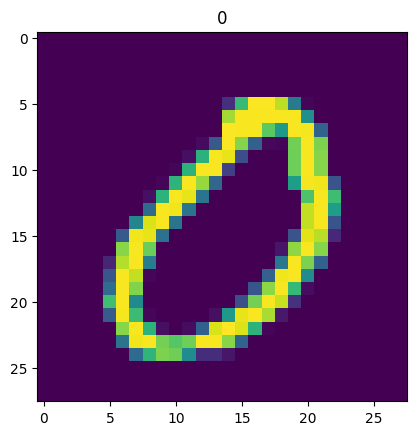

In [7]:
images ,lbl = valid_set[2]

plt.imshow(images.permute(1,2,0))
plt.title(lbl)

In [8]:

from torch.utils.data import DataLoader


In [9]:
bs = 64

train_loader = DataLoader(train_set,batch_size = bs , shuffle=True)
test_loader = DataLoader(test_set,batch_size = bs , shuffle=True)
valid_loader = DataLoader(valid_set,batch_size = bs , shuffle=True)

In [10]:
print(len(train_loader))
print(len(test_loader))
print(len(valid_loader))

782
157
157


In [11]:
for images,label in train_loader:
  break

print(images.shape)
print(label.shape)


torch.Size([64, 1, 28, 28])
torch.Size([64])


In [12]:
class DigitModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn_block = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 8 , kernel_size = (3,3), padding = 1),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Conv2d(in_channels = 8 , out_channels = 16 , kernel_size = (3,3),padding = 1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(in_channels = 16, out_channels = 32 , kernel_size = (3,3), padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
    )

    self.linear_block = nn.Sequential(
        nn.Flatten(),
        nn.Linear(32*7*7,512),
        nn.ReLU(),
        nn.Dropout(p = 0.5),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(256,10)
    )

  def forward(self,images):
    x = self.cnn_block(images)
    logits = self.linear_block(x)

    return logits

In [13]:
model = DigitModel()
model.to("cuda")

DigitModel(
  (cnn_block): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_featu

In [14]:
def multi_class_accuracy(y_pred,y_true):
  top_p , top_class = y_pred.topk(1,dim=1)
  lst_correct = top_class == y_true.view(*top_class.shape)
  return torch.mean(lst_correct.type(torch.FloatTensor))


In [15]:
def train_fn(model,data_loader,err_fn, optimizer):
  model.train()

  total_loss = 0.0
  total_acc = 0.0

  for images,labels in tqdm(data_loader):
    images = images.to("cuda")
    labels = labels.to("cuda")

    optimizer.zero_grad()
    logits = model(images)
    loss = err_fn(logits,labels)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multi_class_accuracy(logits,labels)

  return total_loss / len(data_loader) , total_acc / len(data_loader)

In [16]:
def eval_fn(model,data_loader,err_fn):
  model.eval()

  total_loss = 0.0
  total_acc = 0.0

  with torch.no_grad():

    for images,labels in tqdm(data_loader):
      images = images.to("cuda")
      labels = labels.to("cuda")

      logits = model(images)
      loss = err_fn(logits,labels)

      total_loss += loss.item()
      total_acc += multi_class_accuracy(logits,labels)

  return total_loss / len(data_loader) , total_acc / len(data_loader)

In [17]:
err_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.003)

In [18]:
best_valid_loss = np.Inf

for i in range(7):
  train_loss,train_acc = train_fn(model,train_loader,err_fn,optimizer)
  valid_loss,valid_acc = eval_fn(model,valid_loader,err_fn)

  print(f" EPOCH {i+1} :- Train_loss : {train_loss} , Train_acc : {train_acc}")
  print(f" EPOCH {i+1} :- valid_loss : {valid_loss} , valid_acc : {valid_acc}")

  if valid_loss < best_valid_loss :
    torch.save(model.state_dict(),"best_weights.pt")
    print("Saved best model")
    best_valid_loss = valid_loss

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

 EPOCH 1 :- Train_loss : 0.752653882193291 , Train_acc : 0.7401294708251953
 EPOCH 1 :- valid_loss : 0.2497623627115587 , valid_acc : 0.9275477528572083
Saved best model


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

 EPOCH 2 :- Train_loss : 0.3724237490359627 , Train_acc : 0.884650707244873
 EPOCH 2 :- valid_loss : 0.18616738289025178 , valid_acc : 0.9454618096351624
Saved best model


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

 EPOCH 3 :- Train_loss : 0.29778498774656403 , Train_acc : 0.9094069600105286
 EPOCH 3 :- valid_loss : 0.1705706937321622 , valid_acc : 0.9486464858055115
Saved best model


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

 EPOCH 4 :- Train_loss : 0.2551097811421241 , Train_acc : 0.9217751026153564
 EPOCH 4 :- valid_loss : 0.14826465842972517 , valid_acc : 0.9554139971733093
Saved best model


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

 EPOCH 5 :- Train_loss : 0.23100959404092997 , Train_acc : 0.9304467439651489
 EPOCH 5 :- valid_loss : 0.13480595668932055 , valid_acc : 0.9611862897872925
Saved best model


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

 EPOCH 6 :- Train_loss : 0.2178314115299517 , Train_acc : 0.9349624514579773
 EPOCH 6 :- valid_loss : 0.11962313226358906 , valid_acc : 0.9637739062309265
Saved best model


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

 EPOCH 7 :- Train_loss : 0.20437434162287152 , Train_acc : 0.9393582344055176
 EPOCH 7 :- valid_loss : 0.11482503218872911 , valid_acc : 0.9666600227355957
Saved best model


In [70]:
def view_classify(img, ps):

    classes = np.arange(0, 10)
    img = img.cpu()
    ps = ps.cpu()
    ps = ps.data.numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None


In [71]:
weights = torch.load("best_weights.pt")
model.load_state_dict(weights)

<All keys matched successfully>

tensor(8, device='cuda:0')


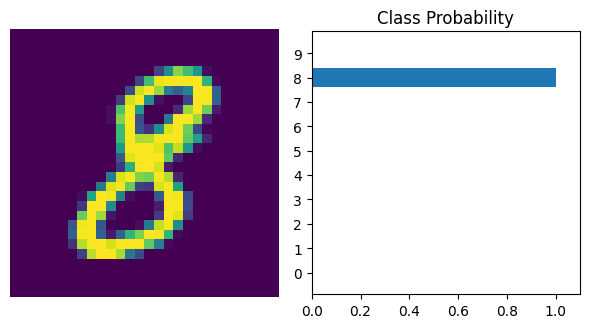

In [93]:

image,label = test_set[110]
model.eval()
image = image.to("cuda")
with torch.no_grad():
  logits = model(image.unsqueeze(0))
  ps = torch.nn.Softmax(dim=1)(logits)[0]
  print(ps.argmax())
  view_classify(image,ps)



tensor(6, device='cuda:0')